In [3]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile
from qiskit.tools.monitor import job_monitor

# import basic plot tools
from qiskit.visualization import plot_histogram

In [ ]:
aer_sim = Aer.get_backend('aer_simulator')

In [4]:
# Função que cria os oráculos de acordo com tipo e quantidade de qubits
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    return oracle_qc

In [5]:
# Aplica o algoritmo de Deutsch-Jozsa basicamente contornando-o com portas de Hadamard
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

## Oráculo para função balanceada

In [6]:
n = 5
oracle_qc = dj_oracle('balanced', n)
oracle_gate = oracle_qc.to_gate()
oracle_gate.name = "Oracle" # To show when we display the circuit
dj_circuit = dj_algorithm(oracle_gate, n)

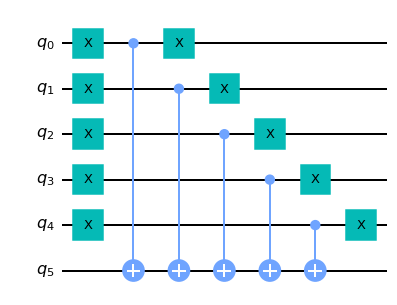

In [8]:
oracle_qc.draw()

Deutsch-Jozsa com oráculo para função balanceada

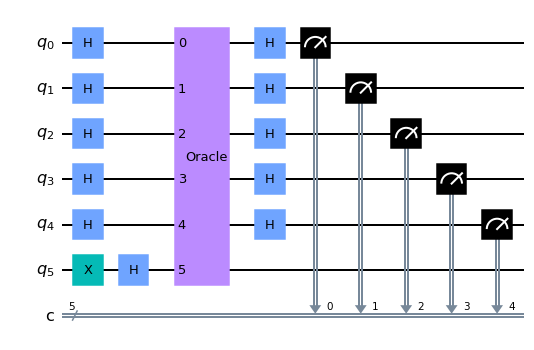

In [9]:
dj_circuit.draw()

Simulando Deutsch-Jozsa com oráculo para função balanceada

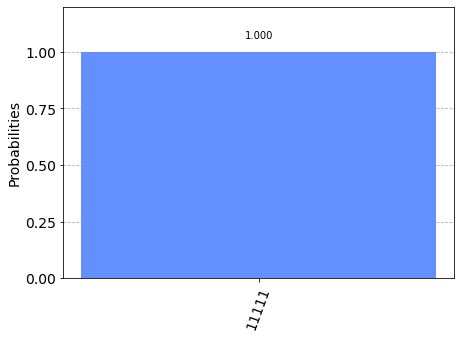

In [16]:
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
qobj = assemble(transpiled_dj_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

In [17]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
def get_less_busy_backend():
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                       not x.configuration().simulator and x.status().operational==True))
    print("least busy backend: ", backend)
    return backend

ibmqfactory.load_account:WARNING:2021-07-04 22:07:10,732: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_16_melbourne


In [18]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
def run_circuits_on_backend(ckt, backend):
    shots = 1024
    transpiled_dj_circuit = transpile(ckt, backend, optimization_level=3)
    job = backend.run(transpiled_dj_circuit)
    job_monitor(job, interval=2)
    results = job.result()
    
    return results.get_counts()

Rodando Deutsch-Jozsa com oráculo para função balanceada em computador quântico real

In [ ]:
# Get the results of the computation
backend = get_less_busy_backend()
answer = run_circuits_on_backend(dj_circuit, backend)
plot_histogram(answer)

## Oráculo para função constante

In [21]:
n = 5
oracle_qc_c = dj_oracle('constant', n)
oracle_gate_c = oracle_qc_c.to_gate()
oracle_gate_c.name = "Oracle" # To show when we display the circuit
dj_circuit_c = dj_algorithm(oracle_gate_c, n)

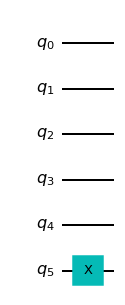

In [22]:
oracle_qc_c.draw()

Simulando Deutsch-Jozsa com oráculo para função constante

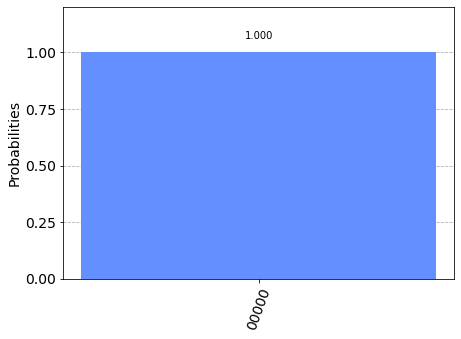

In [23]:
transpiled_dj_circuit_c = transpile(dj_circuit_c, aer_sim)
qobj_c = assemble(transpiled_dj_circuit_c)
results_c = aer_sim.run(qobj_c).result()
answer_c = results_c.get_counts()
plot_histogram(answer_c)

Rodando Deutsch-Jozsa com oráculo para função constante em computador quântico real

Job Status: job has successfully run


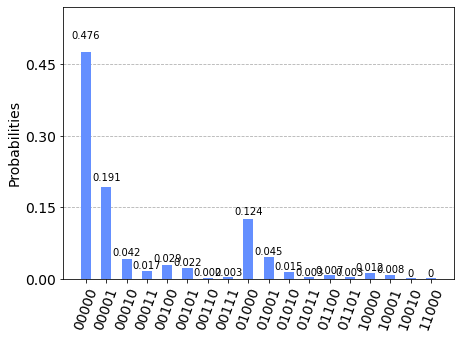

In [24]:
answer_c = run_circuits_on_backend(dj_circuit_c, backend)
plot_histogram(answer_c)